<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/Fake_Butterfly_Demo.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/Fake_Butterfly_Demo.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/Fake_Butterfly_Demo.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/Fake_Butterfly_Demo.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# <span style="color:#FF6D04">**Finding Fake Images with FiftyOne Brain**

## A guided example using a butterfly dataset

### Download the data from kaggle

In [1]:
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

100%|█████████████████████████████████████████| 226M/226M [27:13<00:00, 466kB/s]
100%|█████████████████████████████████████████| 226M/226M [27:13<00:00, 145kB/s]


### Import the data into FiftyOne using `fo.Dataset.from_dir()`, a great start for loading custom dataset formats

In [13]:
import fiftyone as fo


dataset = fo.Dataset.from_dir(
    dataset_dir="./butterfly/train",
    dataset_type=fo.types.ImageDirectory,
    name="butterfly-demo",
    overwrite=True
)
dataset.persistent = True

 100% |███████████████| 6499/6499 [752.5ms elapsed, 0s remaining, 8.6K samples/s]      


### Load the labels in from the csv into a pandas dataframe

In [14]:
import pandas as pd

df = pd.read_csv("./butterfly/Training_set.csv")

df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


### To add the labels to our dataset, we loop through every sample and look for the label with the matching filepath of our sample, adding the class to our FO sample

In [15]:
import os 

for sample in dataset:
    filepath = sample.filepath
    filename = os.path.basename(filepath)
    label = df.loc[df['filename'] == filename, 'label'].values[0]
    sample["class"] = fo.Classification(label=label)
    sample.save()



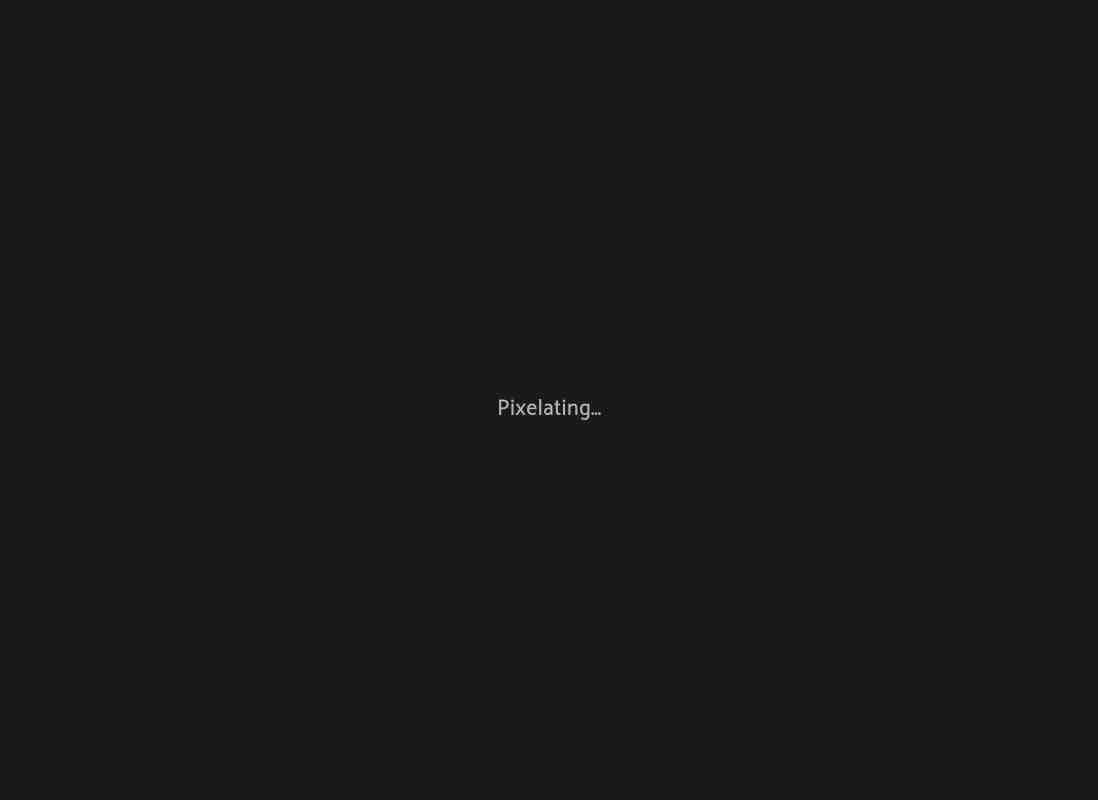

In [6]:
session = fo.launch_app(dataset)

### Load in similarly our synthetic images created from [Stable Diffusion](https://stablediffusionweb.com/)

In [22]:
for filename in os.listdir("./sd_images"):
    print(filename)
    sample = fo.Sample(filepath="./sd_images/" + filename, tags=["Diffusion"])
    sample["class"] = fo.Classification(label="MONARCH")
    dataset.add_sample(sample)
dataset.save()

sd_003.png
sd_001.png
sd_002.png
sd_004.png
sd_005.png


Needed for Brain run if you dont have

In [ ]:
!pip3 install numba

### Start the Brain run! We will use the default model and do it over all whole dataset. It may take some time to run

In [ ]:
import fiftyone.brain as fob

# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    num_dims=2,
    brain_key="emb",
    verbose=True,
    seed=51,
)


### Lets start by taking a look at only our Monarch Butterflies. Open the app and take a look at the embedding panel.

In [3]:
from fiftyone import ViewField as F
view = dataset.filter_labels("class", F("label") == "MONARCH")

In [4]:
view

Dataset:     butterfly-demo
Media type:  image
Num samples: 95
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    class:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. FilterLabels(field='class', filter={'$eq': ['$class.label', 'MONARCH']}, only_matches=True, trajectories=False)


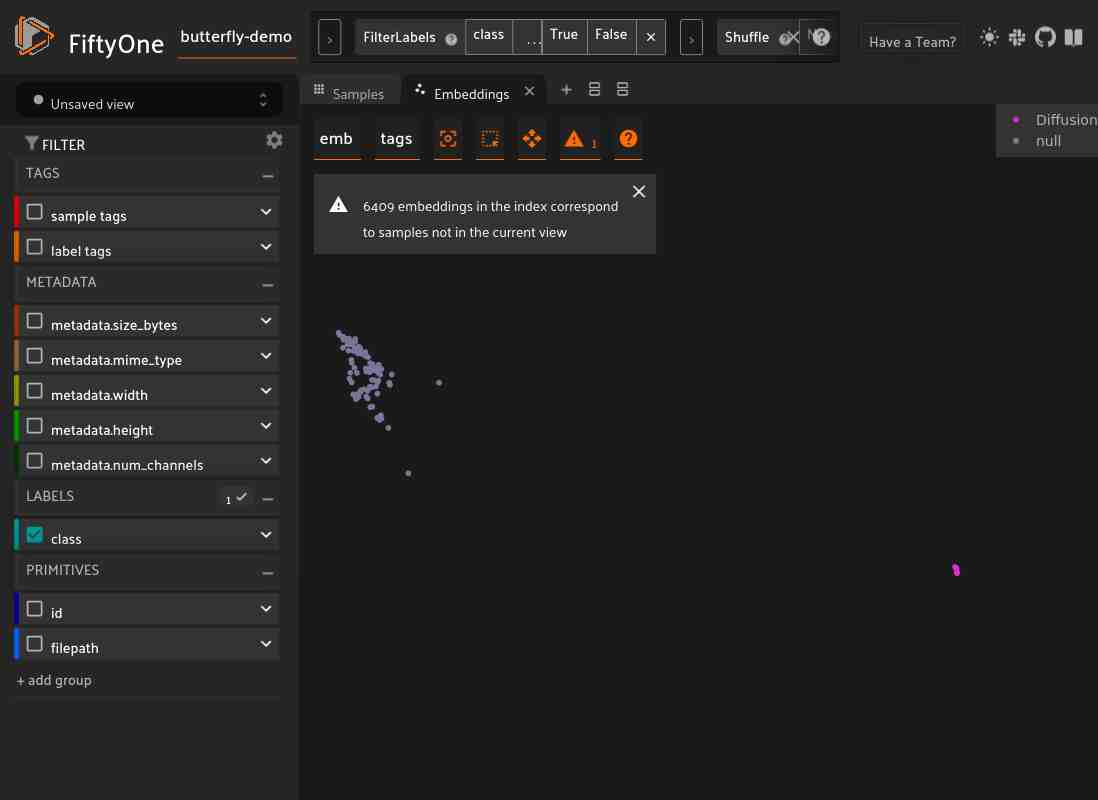

In [7]:
session.view = view.shuffle()

### Next we can see the whole dataset to look at how our synthetic images despite being far from our other Monarch butterflies hide among other classes!

In [8]:
session.view = dataset.shuffle()